## Time Series Forecasting with Lag-Llama

In this tutorial, we'll use the Lag-Llama model, an open source foundation model, to predict the overnight low temperatures in a [zero-shot learning scenario](https://www.ibm.com/think/topics/zero-shot-learning). Zero-shot learning is when the model is not trained on the data it’s trying to predict. It’s an interesting test of how well our model can detect and respond to the patterns present in the time series.  

Foundation models for time series data are similar to other forms of generative AI that are trained on large-scale time series datasets and can output either deterministic or probabilistic forecasts. A time series foundation model can create forecasts without pretraining, similar to how a large language model (LLM) can output text without being pretrained on a task. Lag-Llama is a general-purpose foundation model for probabilistic time series forecasting on univariate datasets that uses a transformer architecture. You can read more about it in the paper here: [Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting by Kashif Rasul, Arjun Ashok, Andrew Robert Williams, Hena Ghonia, et. al](https://arxiv.org/abs/2310.08278).

To unpack this a little, a probabilistic forecast is one that generates a probability distribution of values for each forecast step rather than just a single value. This method is helpful to indicate how certain the model is about its predictions. A wide distribution would indicate low certainty while a narrower range of values would indicate that the model is fairly certain about its predictions. Purely deterministic forecasts don't tell us how certain they are about their forecasts, which can be problematic if we're trying to ascertain how confident we should be in our forecasts.

Given this background about the Lag Llama model and time series forecasting, let's see how the model performs in our experiment.

Note: This notebook is designed to run within [IBM watsonx.ai Studio](https://www.ibm.com/docs/en/watsonx/saas?topic=services-watsonxai-studio) using the Runtime 24.1 on Python 3.11 S [environment](https://www.ibm.com/docs/en/watsonx/saas?topic=tools-compute-options-notebook-editor). 

### Step 1: Clone the Lag-Llama repository and install libraries 

To use the [Lag-Llama](https://github.com/time-series-foundation-models/lag-llama) model, we'll clone the open source GitHub repository and install it in our IBM watsonx.ai Studio project. 

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 486, done.
remote: Counting objects: 100% (322/322), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 486 (delta 208), reused 259 (delta 168), pack-reused 164 (from 1)
Receiving objects: 100% (486/486), 271.19 KiB | 2.92 MiB/s, done.
Resolving deltas: 100% (250/250), done.


In [2]:
%cd lag-llama

/home/wsuser/work/lag-llama


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


Next we need to install pretrained model weights from the HuggingFace repository where they're stored. To do this, we use the Hugging-Face CLI to download the trained Lag-Llama checkpoint and install it in the same `lag-llama` directory within our watsonx.ai Studio environment. If you're using a different environment to run this notebook, you'll want to make sure to install the weights in the same directory where you've downloaded the model.

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir ~/work/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /home/wsuser/.cache/huggingface/hub/tmpnla90i6o
lag-llama.ckpt: 100%|██████████████████████| 29.5M/29.5M [00:00<00:00, 43.2MB/s]
/home/wsuser/work/lag-llama/lag-llama.ckpt


### Step 2: Import libraries and data 

Next, we need to import libraries to work with Lag-Llama. The library that the Lag-Llama team built to work with Lag-Llama uses [GluonTS](https://ts.gluon.ai/stable/), a PyTorch based library for working with time series data and forecasting models. You might need to restart the kernel after installing the required libraries.

In [5]:
from itertools import islice

import pandas as pd
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

import torch

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset

from lag_llama.gluon.estimator import LagLlamaEstimator
from ibm_watson_studio_lib import access_project_or_space

/tmp/wsuser/ipykernel_106/45153676.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Next, we load the data. You can find the `.csv` file that was used in our Github repo. In this case, I've loaded the dataset as a [data asset from within the watsonx.ai Studio project](https://www.ibm.com/docs/en/watsonx/saas?topic=scripts-loading-accessing-data-in-notebook#add-file-local). In order to retrieve the data asset from the project, you'll need a [project access token](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?context=wx). If you're running this notebook in a different environment, you can load the dataset in whatever way is easiest for you. Once the data is loaded, we can see this time series data contains the hourly temperatures in New York during the months of October and November, gathered from [ACIS Web Services](http://www.rcc-acis.org/docs_webservices.html). 

In [ ]:
wslib = access_project_or_space({'token':'<YOUR_WATSONX.AI_STUDIO_PROJECT_TOKEN>'})

# Fetch the data from a file
my_file = wslib.load_data('nyc_hourly_temp.csv')

# Read the CSV data file into a pandas DataFrame
my_file.seek(0)
df = pd.read_csv(my_file)

df.head()

The data has some missing readings that we need to fill in by interpolating between values, so that there are no missing values in the time series. Because the dataset is a univariate dataset and contains values for only one variable, each row consists simply of a date and a temperature reading in Fahrenheit.

In [8]:
for col in df.columns:
# Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index("Datetime")
df = df.interpolate('linear')
df.head()

,Temp (F)
Datetime,
2023-10-01 00:00:00,61.0
2023-10-01 01:00:00,60.5
2023-10-01 02:00:00,60.0
2023-10-01 03:00:00,60.0
2023-10-01 04:00:00,60.0


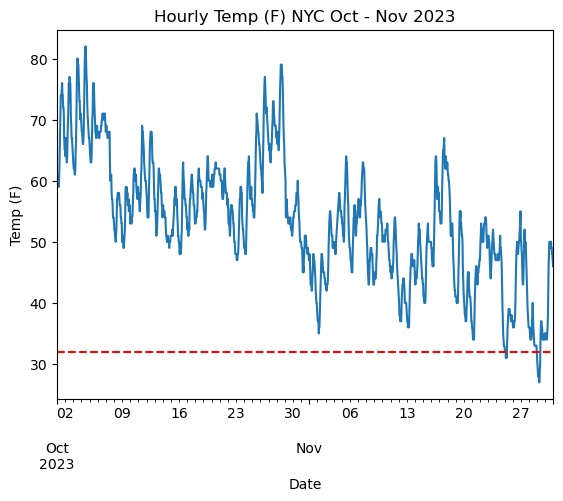

In [8]:
# Plot the time series
df['Temp (F)'].plot()
plt.title('Hourly Temp (F) NYC Oct - Nov 2023')
plt.xlabel('Date')
plt.ylabel('Temp (F)')
plt.axhline(y=32.0, color='r', linestyle='--')
plt.show()

### Step 3: Create a zero-shot predictor 

We'll create some configuration settings to use with our model. The `prediction_length` is how many time steps each prediction should contain. Because our data is daily, we'll predict the next week of temperatures in each forecast. The `context_length` sets the number of time points back into the past that the model should look for lagged correlations. We don't want this to be too wide or too narrow, for each dataset the optimal value will be different.

In [9]:
prediction_length = 8 # we'll predict out 8 hours
context_length = prediction_length * 3 * 7 # how many lags to use as context, how far we look back into the future, one week in this case
num_samples = 20 # how many samples for each distribution
device = "cpu" # where should we run it, options are "cuda" or "cpu"

batch_size = 64

Now we create the forecaster. This step consists of two key steps: first, creating a `LagLlamaEstimator` which uses all the parameters copied from the downloaded Lag-Llama model. The second step is to create a `LagLlamaPredictor` using the `create_predictor()` method of the estimator. This allows us to pass a `context_length` sized window of data to get forecasts from the predictor.

In [10]:
ckpt_path = "lag-llama.ckpt"
ckpt = torch.load(ckpt_path, map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

zs_estimator = LagLlamaEstimator(
        ckpt_path=ckpt_path,
        prediction_length=prediction_length,
        context_length=context_length,
        device=torch.device('cpu'),

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=True,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

zs_predictor = zs_estimator.create_predictor(zs_estimator.create_transformation(), zs_estimator.create_lightning_module())

### Step 4: Zero-shot forecasting 

In this step, we'll ask the model to create 6 overnight forecasts focused on the last week of November. We can use the `make_evaluation_predictions` from the `gluonts.evaluation` library to generate our forecasts.

In [11]:
valid_end = round(len(df) * 0.9)
date_list = pd.date_range(df[valid_end:].index[2] + pd.Timedelta(hours=6), periods=6, freq="1d").tolist()

zs_forecasts = []
zs_tss = []

for d in date_list:
  print(d)
  forecast_it, ts_it = make_evaluation_predictions(
          dataset=PandasDataset(df[:d], freq="1h", target="Temp (F)"),
          predictor=zs_predictor,
          num_samples=num_samples
  )
  zs_forecasts.append(list(forecast_it))
  zs_tss.append(list(ts_it))

2023-11-25 06:00:00
2023-11-26 06:00:00
2023-11-27 06:00:00
2023-11-28 06:00:00
2023-11-29 06:00:00
2023-11-30 06:00:00


To evaluate the forecasts, we use an `evaluator` object, also from the `gluonts.evaluation` library. We’ll generate several metrics that we can use to evaluate the accuracy of our forecasts, but we’ll focus on Mean Absolute Percentage Error or [MAPE](https://ts.gluon.ai/stable/api/gluonts/gluonts.evaluation.metrics.html).

In [12]:
evaluator = Evaluator()
zs_a_metrics = [] # aggregated forecast metrics, we'll use the MAPE metric to evaluate
zs_t_metrics = [] # information about each time series, we'll use this to graph

for (t,s) in zip(zs_tss, zs_forecasts):
  agg_metrics, ts_metrics = evaluator(t, s)
  zs_a_metrics.append(agg_metrics)
  zs_t_metrics.append(ts_metrics)

Running evaluation: 1it [00:00,  1.20it/s]
Running evaluation: 1it [00:00,  1.05it/s]
Running evaluation: 1it [00:00,  1.17it/s]
Running evaluation: 1it [00:00,  1.14it/s]
Running evaluation: 1it [00:00,  1.25it/s]
Running evaluation: 1it [00:00,  1.25it/s]


Once we have the evaluations for each prediction, we can graph each prediction. The generated chart shows each of our 6 zero-shot forecasts (shown in green) and the time series data that lead up to it (the blue line). For each forecast we can see the mean forecast as the green line, the boundaries of the 50% prediction interval in dark green and the boundaries of the 90% prediction interval in lighter green. This shows us how certain our model is about the forecast at each step. This is the advantage of a probabilistic model: it will show us how certain it is at each step in the forecast.

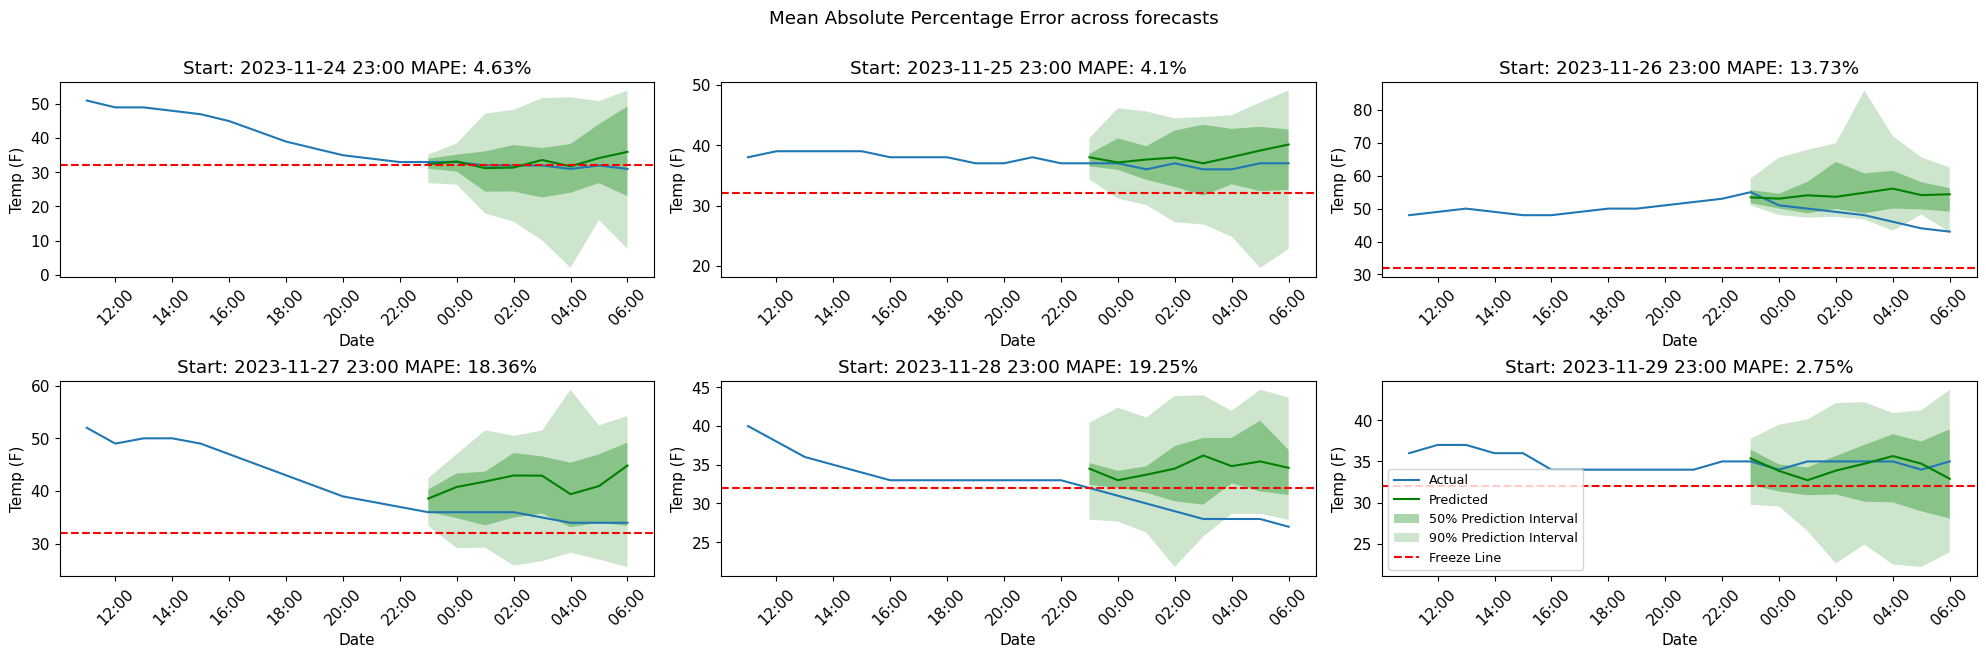

In [13]:
plt.figure(figsize=(20, 9))
plt.rcParams.update({'font.size': 11})
date_formater = mdates.DateFormatter('%H:%M') #%b %d \'%y %H')


for idx in range(len(zs_forecasts)):
  ax = plt.subplot(3, 3, idx+1)
  t = zs_tss[idx][0][zs_forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(hours=12):]
  
  smape = float(f'{zs_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
  smape = float(f'{smape:.2f}')
  ax.set_title("Start: " + str(zs_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
  plt.plot(t.index.to_timestamp(), t[0])
  ax.xaxis.set_major_formatter(date_formater)
  #ax.set_ticks()
  #ax.set_xticklabels(fontsize="small") #["Day " + str(i + 1) for i in range(7)], fontsize="small")
  ax.set_xlabel('Date')
  ax.set_ylabel('Temp (F)')
  zs_forecasts[idx][0].plot(color='g')
  plt.axhline(y=32.0, color='r', linestyle='--')
  plt.xticks(rotation=45)

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.legend(["Actual", "Predicted",'50% Prediction Interval', '90% Prediction Interval', "Freeze Line"], fontsize="small")
plt.show()

In this tutorial you learned about foundation models for forecasting. You used the Lag-Llama model, a foundation model trained on time series data specifically built for forecasting. You used the base model to perform zero-shot forecasting on an hourly temperature dataset. 

You can learn more about Lag-Llama at the [Lag-Llama GitHub Repository](https://github.com/time-series-foundation-models/lag-llama). 

To learn about IBM's foundation models for time series forecasting see [Using the IBM Granite models for time series forecasting](https://developer.ibm.com/tutorials/awb-foundation-model-time-series-forecasting/).

For a longer version of this tutorial including fine-tuning of the model, see [Time Series Forecasting with Lag-Llama](https://www.ibm.com/think/tutorials/lag-llama).